In [61]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn import multiclass
from sklearn import svm
from scipy.stats import ttest_ind
import os
from scipy.spatial import distance
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import linear_model
from scipy import stats
import random
sns.set_style("white")
def zScore(M):
    return (M-M.mean(axis=0))/M.std(axis=0)
def cdist_df(df1,df2):
    df1T,df2T=df1.T, df2.T
    corrM=1-distance.cdist(df1T,df2T,metric='correlation')
    return pd.DataFrame(corrM,index=df1.columns,columns=df2.columns  )

In [97]:
unifiedChipDataDfDir='/cellar/users/btsui/Data/Project/KangZhang/deconData/450k_5mc_site_overlap.pickle'

subsetCfDnaDiseases=['nsclc','normal']
#methylation data input dir
DataInDir="./featureMatrix/"
#results output dirs
resultBaseDir='./Results/'
#input fdirs
#['raw', 'beta', 'normed','MCB_sample_filtered','MCB_with_burden','beta_plus_readDf']
featureSpace='raw'

In [79]:
inFeatureDf=pd.read_pickle(DataInDir+featureSpace+'_readcount.pickle')[subsetCfDnaDiseases]

cancer_vs_cancer_reg=LogisticRegression(multi_class= 'multinomial',solver='newton-cg')

In [80]:
effect_threshold=0.25

In [81]:
raw_chip_df=pd.read_pickle('../../pan_cancer/cfDNA_data_inter/450k_5mc_site_overlap.pickle')

padlock_cpg_sites=inFeatureDf.index.get_level_values(1).unique()

#sub_chip_df.head()

## replace lasso markers with lasso_c_n_markers
cpg_m=raw_chip_df.index.isin(padlock_cpg_sites)
sub_chip_df=raw_chip_df[cpg_m].dropna()
cancer_m=sub_chip_df.columns.get_level_values(0).isin(['luad','lusc'])
sample_type_m=sub_chip_df.columns.get_level_values('SAMPLE_TYPE')=='01'
cancer_df=sub_chip_df.loc[:,cancer_m&sample_type_m
                    ]
cancer_S=cancer_df.median(axis=1)
normal_S=sub_chip_df.loc[:,('normal','11')  ].median(axis=1)
dm_S=cancer_S-normal_S#['luad']['01']
dm_S=dm_S.dropna()



dm_filtered_cpgs=dm_S.index[dm_S.abs()>=effect_threshold]
dm_filtered_cpgs=pd.Series(dm_filtered_cpgs).sort_values()
distanceToPrevMcb=dm_filtered_cpgs.str.split('-').str[1].astype(np.int).diff()
unique_dm_markers=(dm_filtered_cpgs[~(distanceToPrevMcb<100)])
unique_dm_markers.index=unique_dm_markers.values

In [82]:
print '# of markers:',len(unique_dm_markers)

# of markers: 67


In [83]:

myMarkerS=pd.concat([unique_dm_markers.index.to_series(), unique_dm_markers.index.to_series()], keys=['mc','non_mc'])

### do normal vs cancer

In [84]:
feautureLabel='TSS'

In [85]:
test_size_ratio=0.5

In [86]:
clinDf=pd.read_excel('tmp_clin.xlsx')

In [87]:
patientsWBurden=clinDf.index[clinDf['tumor_burden'].str.upper()=='Y']

In [88]:
reI_Df=inFeatureDf.copy().T

tmpMetaDf=reI_Df.index.to_series().to_frame().reset_index()
m=tmpMetaDf['ID'].isin(patientsWBurden)
m2=tmpMetaDf['TSS']=='normal'
m3=tmpMetaDf.TSS.isin(subsetCfDnaDiseases)
tmpMetaDf['tumor_burden']=((m&m3)|m2)

reI_Df.index=tmpMetaDf.set_index(['TSS','ID','tumor_burden']).index
reI_Df=reI_Df.sort_index()

### make sure the 

In [89]:
myInDf=reI_Df.loc[reI_Df.index.get_level_values('tumor_burden').values]

orderScrambedDf=myInDf.sample(n=myInDf.shape[0],random_state=0)
myTmpDfList=[]
for g,subDf in  orderScrambedDf.groupby(level='TSS'):
    myTmpDfList.append(subDf.head(int(subDf.shape[0]*test_size_ratio)))
X_train=pd.concat(myTmpDfList,axis=0)
X_test=reI_Df[~reI_Df.index.isin(X_train.index)]


In [90]:
myTrainTestDf=pd.concat([X_train,X_test],axis=0,keys=['train','test']).sort_index()

In [91]:
myTrainTestDf.index.names=['Status','TSS','ID','tumor_burden']

In [92]:
myTrainTestDf.groupby(level=['Status','tumor_burden','TSS']).size()

Status  tumor_burden  TSS   
test    False         nsclc      315
        True          normal    1742
                      nsclc      369
train   True          normal    1742
                      nsclc      368
dtype: int64

In [93]:

#lasso_markers=unique_dm_markers

### build models

In [94]:
cancer_vs_norm_reg=LogisticRegression(multi_class= 'multinomial',
                                      solver='newton-cg')

m1=X_train.columns.isin(myMarkerS.index)
myFeatureList=X_train.columns[m1]
sub_X_train=X_train.loc[:,m1]
y_labels=sub_X_train.index.get_level_values('TSS')!='normal'
cancer_vs_norm_reg.fit(X=sub_X_train,y=y_labels)
y_labels


array([False, False, False, ...,  True,  True,  True], dtype=bool)

### generate score for both training and testing sets

In [95]:
subTrainTestDf=myTrainTestDf.loc[:,m1]
all_score=cancer_vs_norm_reg.predict_proba(
subTrainTestDf)[:,1]
cancer_vs_normal_probaS=pd.Series(all_score,index=myTrainTestDf.index)
all_score=cancer_vs_norm_reg.decision_function(subTrainTestDf)#[:,1]
cancer_vs_normal_scoreS=pd.Series(all_score,index=myTrainTestDf.index)

### evaluate performance in test set

ROC-AUC: 0.952129595923


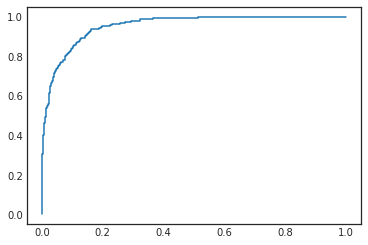

In [96]:
fig,ax=plt.subplots()
m2=cancer_vs_normal_probaS.index.get_level_values('tumor_burden').values
m1=(cancer_vs_normal_probaS.index.get_level_values('Status')=='test')
m3=cancer_vs_normal_probaS.index.get_level_values('TSS').isin(subsetCfDnaDiseases)
inEvalS=cancer_vs_normal_probaS.loc[(m1&m3)&m2]
y_true=inEvalS.index.get_level_values(feautureLabel).values!='normal'
fpr,tpr,thresholds= metrics.roc_curve(y_true,inEvalS)
normal_cancer_rocDf=pd.DataFrame({'tpr':tpr,'fpr':fpr,'threshold':thresholds})
auc=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr)
print 'ROC-AUC:',auc

### generate cancer vs cancer models

In [26]:
classificationMethod='logistic_reg'

resultPrefix='./interData/'+featureSpace+'_classification_'+classificationMethod


#cancerVsCancerProbaDf.loc[:,'cancer_vs_normal']=cancer_vs_normal_probaS.loc[:]
cancer_vs_normal_probaS.to_frame('cancer_vs_normal').to_pickle(
    resultPrefix+'_result_proba.pickle')
cancer_vs_normal_scoreS.to_frame('cancer_vs_normal').to_pickle(
    resultPrefix+'_result_dot.pickle')
cancer_vs_normal_coeff=pd.Series(cancer_vs_norm_reg.coef_[0,:],index=subTrainTestDf.columns)
cancer_vs_normal_coeff.loc[('intercept','intercept')]=cancer_vs_norm_reg.intercept_[0]

coeffDf=pd.DataFrame({'normal_vs_cancer':cancer_vs_normal_coeff})

coeffDf.to_pickle(resultPrefix+'_classification_coefficients.pickle')


In [27]:
myCoeffS=pd.Series(cancer_vs_norm_reg.coef_[0],index=sub_X_train.columns)
myCoeffS.to_pickle(resultPrefix+'_marker_group.pickle')

In [28]:
resultPrefix+'_classification_coefficients.pickle'

'./interData/raw_classification_lasso_classification_coefficients.pickle'